In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Loading the data
image_size = (161, 161)
batch_size = 32


train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/binaryData/2mass",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2248 files belonging to 2 classes.
Using 1799 files for training.
Using 449 files for validation.


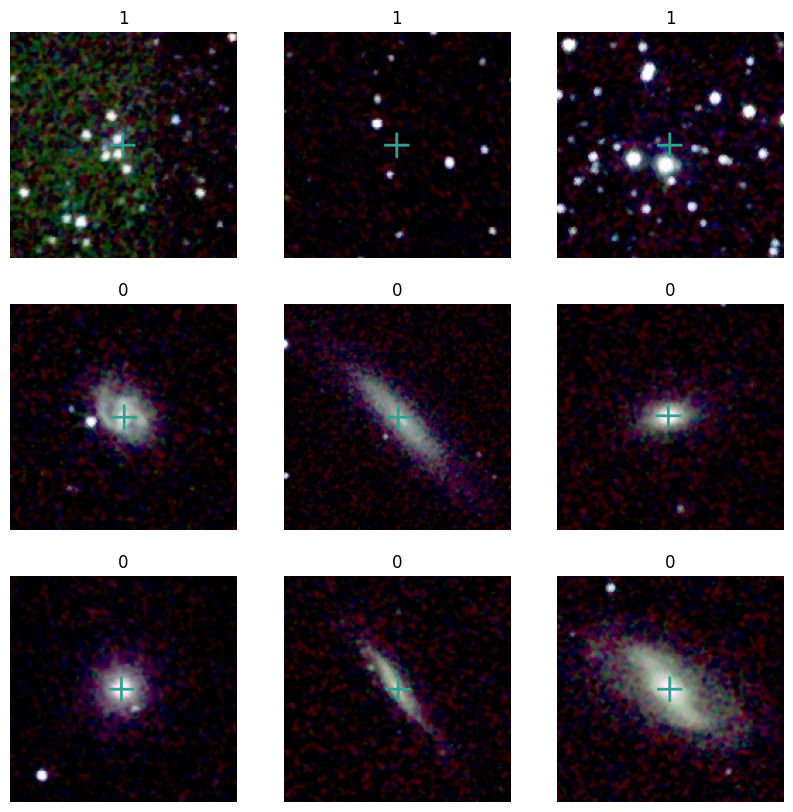

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

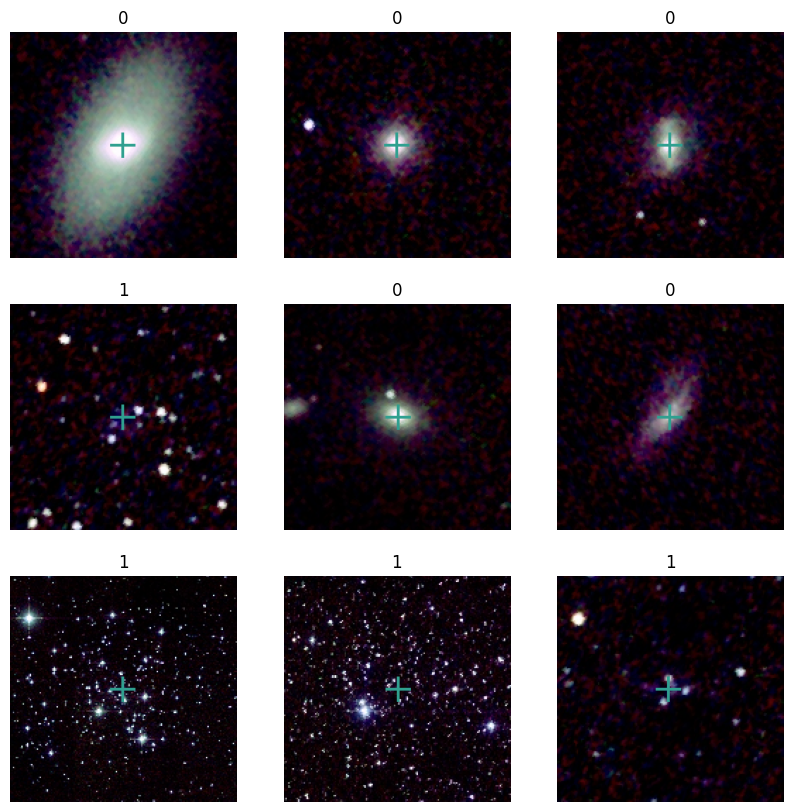

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Image data augmentation

# To do

In [ ]:
# Proprocessing

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Making the model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # entry block
    x = layers.Rescaling(1. / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

In [ ]:
model = make_model(
    input_shape=image_size + (3,),
    num_classes=2,
)

In [ ]:
# Training

epochs = 15

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    verbose=2,
)

Epoch 1/5
57/57 - 26s - loss: 0.0386 - accuracy: 0.9872 - val_loss: 0.1348 - val_accuracy: 0.9666 - 26s/epoch - 462ms/step
Epoch 2/5
57/57 - 19s - loss: 0.0223 - accuracy: 0.9928 - val_loss: 0.1169 - val_accuracy: 0.9621 - 19s/epoch - 338ms/step
Epoch 3/5
57/57 - 17s - loss: 0.0297 - accuracy: 0.9894 - val_loss: 0.2145 - val_accuracy: 0.9666 - 17s/epoch - 304ms/step
Epoch 4/5
57/57 - 17s - loss: 0.0191 - accuracy: 0.9933 - val_loss: 0.4667 - val_accuracy: 0.8619 - 17s/epoch - 297ms/step
Epoch 5/5
57/57 - 17s - loss: 0.0147 - accuracy: 0.9944 - val_loss: 0.1080 - val_accuracy: 0.9866 - 17s/epoch - 302ms/step


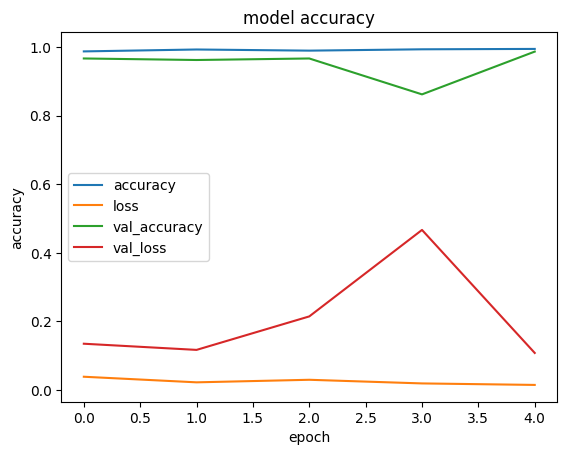

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','loss', "val_accuracy", "val_loss"])
plt.show()

1/1 [==============================] - 0s 84ms/step
This image is 100.00% galaxy and 0.00% open cluster.


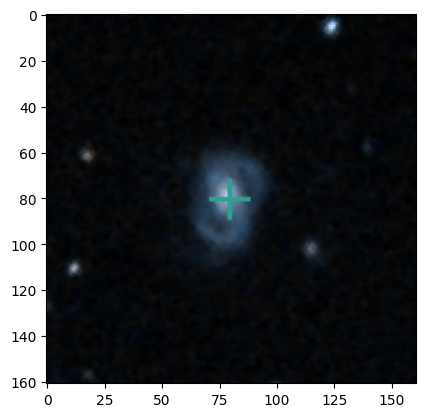

In [ ]:
img = keras.utils.load_img(
    "data/binaryData/dss/galaxy/2949.png", target_size=image_size
)


img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis


plt.imshow(img_array[0] / 255)

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% galaxy and {100 * score:.2f}% open cluster.")


1/1 [==============================] - 0s 20ms/step
This image is 93.64% galaxy and 6.36% open cluster.


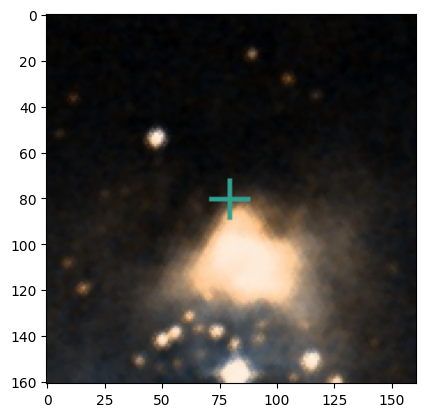

In [ ]:
img = keras.utils.load_img(
    "data/binaryData/dss/open_cluster/2316.png", target_size=image_size
)


img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis


plt.imshow(img_array[0] / 255)

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% galaxy and {100 * score:.2f}% open cluster.")


1/1 [==============================] - 0s 57ms/step
This image is 100.00% galaxy and 0.00% open cluster.


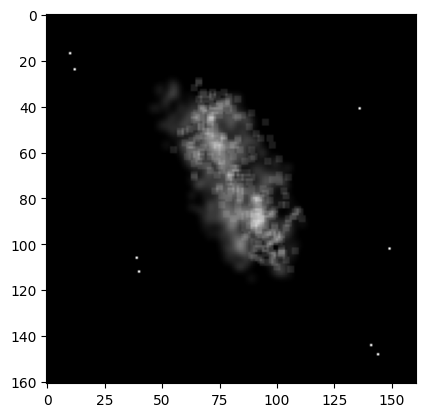

In [ ]:
img = keras.utils.load_img(
    "data/binaryData/fake_galaxy.png", target_size=image_size
)


img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis


plt.imshow(img_array[0] / 255)

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% galaxy and {100 * score:.2f}% open cluster.")


In [ ]:
model.save('data/trained_model')
